<a href="https://colab.research.google.com/github/Akkki28/GNN-MARL/blob/main/GNN_MARLipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GNNActor(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.conv1 = SAGEConv(in_channels=2, out_channels=hidden_dim)
        self.conv2 = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim)

        self.action_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        agent_idx = (data.x[:, 1] == 1.0).nonzero(as_tuple=True)[0]
        if len(agent_idx) == 0:
            agent_idx = torch.tensor([0], dtype=torch.long)

        agent_embedding = x[agent_idx]
        agent_embedding = agent_embedding.mean(dim=0, keepdim=True)

        logits = self.action_head(agent_embedding)
        return logits.squeeze(0)

class MLPCritic(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 * 4, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x = data.x.view(-1)
        v = self.net(x)
        return v


In [4]:
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition', ['obs', 'action', 'log_prob', 'reward', 'value', 'done'])

def compute_gae(transitions, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    next_value = 0

    for t in reversed(transitions):
        delta = t.reward + gamma * next_value * (1 - int(t.done)) - t.value
        gae = delta + gamma * lam * gae * (1 - int(t.done))
        advantages.append(gae)
        next_value = t.value

    advantages.reverse()
    return advantages

class PPOTrainer:
    def __init__(self, actor, critic, env, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, lam=0.95, clip_eps=0.2, epochs=4, batch_size=16):
        self.actor = actor
        self.critic = critic
        self.env = env

        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    def collect_rollout(self, rollout_size=100):
        transitions = []
        obs = self.env.reset()
        done = False
        for _ in range(rollout_size):
            with torch.no_grad():
                logits = self.actor(obs)
                dist = torch.distributions.Categorical(logits=logits)
                action = dist.sample()
                log_prob = dist.log_prob(action)

                value = self.critic(obs).item()

            next_obs, reward, done, _ = self.env.step(action.item())

            transitions.append(Transition(obs, action, log_prob, reward, value, done))
            obs = next_obs

            if done:
                obs = self.env.reset()
                done = False

        return transitions

    def update(self, transitions):
        advantages = compute_gae(transitions, gamma=self.gamma, lam=self.lam)
        advantages = torch.tensor(advantages, dtype=torch.float32)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        obs_list = []
        action_list = []
        old_log_probs = []
        returns = []

        for t, adv in zip(transitions, advantages):
            obs_list.append(t.obs)
            action_list.append(t.action)
            old_log_probs.append(t.log_prob)
            returns.append(t.value + adv.item())

        returns = torch.tensor(returns, dtype=torch.float32)
        old_log_probs = torch.stack(old_log_probs)
        action_list = torch.stack(action_list)

        dataset_size = len(transitions)
        idxs = np.arange(dataset_size)

        for epoch in range(self.epochs):
            np.random.shuffle(idxs)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = idxs[start:end]

                batch_obs = [obs_list[i] for i in batch_idx]
                batch_actions = action_list[batch_idx]
                batch_returns = returns[batch_idx]
                batch_old_log_probs = old_log_probs[batch_idx]
                batch_adv = advantages[batch_idx]

                log_probs_new = []
                values_new = []
                for o in batch_obs:
                    logits = self.actor(o)
                    dist = torch.distributions.Categorical(logits=logits)
                    lp = dist.log_prob(batch_actions[len(log_probs_new)])
                    val = self.critic(o)
                    log_probs_new.append(lp)
                    values_new.append(val)

                log_probs_new = torch.stack(log_probs_new)
                values_new = torch.stack(values_new).squeeze(-1)

                ratio = (log_probs_new - batch_old_log_probs).exp()
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * batch_adv
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values_new, batch_returns)

                self.actor_opt.zero_grad()
                self.critic_opt.zero_grad()
                total_loss = policy_loss + 0.5 * value_loss
                total_loss.backward()
                self.actor_opt.step()
                self.critic_opt.step()

    def train(self, num_iterations=50, rollout_size=100):
        reward_history = []

        for it in range(num_iterations):
            transitions = self.collect_rollout(rollout_size)
            total_reward = sum([t.reward for t in transitions])
            reward_history.append(total_reward / rollout_size)
            self.update(transitions)

            if (it+1) % 5 == 0:
                print(f"Iteration {it+1}/{num_iterations}, AvgReward={reward_history[-1]:.2f}")

        return reward_history


In [5]:
import gym
import torch
import numpy as np
from gym import spaces
from torch_geometric.data import Data

class GraphPatrolEnv(gym.Env):
    def __init__(self, max_steps=50):
        super().__init__()
        self.num_nodes = 4
        self.edge_index = torch.tensor([
            [0, 1, 2, 3],
            [1, 2, 3, 0]
        ], dtype=torch.long)

        self.action_space = spaces.Discrete(2)

        self.max_steps = max_steps
        self.current_step = 0
        self.agent_pos = 0
        self.idleness = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.agent_pos = 0
        self.idleness = np.zeros(self.num_nodes, dtype=np.float32)
        return self._get_observation()

    def step(self, action):
        self.current_step += 1
        neighbors = self._get_neighbors(self.agent_pos)
        next_pos = neighbors[action]

        self.idleness += 1.0
        self.idleness[next_pos] = 0.0

        self.agent_pos = next_pos

        reward = -float(self.idleness.mean())

        done = (self.current_step >= self.max_steps)

        obs = self._get_observation()
        return obs, reward, done, {}

    def _get_observation(self):
        x = []
        for i in range(self.num_nodes):
            is_agent = 1.0 if i == self.agent_pos else 0.0
            x.append([self.idleness[i], is_agent])

        x = torch.tensor(x, dtype=torch.float32)

        data = Data(
            x=x,
            edge_index=self.edge_index
        )
        return data

    def _get_neighbors(self, node):
        left_neighbor = (node - 1) % self.num_nodes
        right_neighbor = (node + 1) % self.num_nodes
        return [left_neighbor, right_neighbor]



Iteration 5/200, AvgReward=-1.67
Iteration 10/200, AvgReward=-1.65
Iteration 15/200, AvgReward=-1.47
Iteration 20/200, AvgReward=-1.46
Iteration 25/200, AvgReward=-1.48
Iteration 30/200, AvgReward=-1.44
Iteration 35/200, AvgReward=-1.45
Iteration 40/200, AvgReward=-1.46
Iteration 45/200, AvgReward=-1.44
Iteration 50/200, AvgReward=-1.45
Iteration 55/200, AvgReward=-1.69
Iteration 60/200, AvgReward=-1.87
Iteration 65/200, AvgReward=-1.90
Iteration 70/200, AvgReward=-1.82
Iteration 75/200, AvgReward=-1.68
Iteration 80/200, AvgReward=-1.83
Iteration 85/200, AvgReward=-1.62
Iteration 90/200, AvgReward=-1.47
Iteration 95/200, AvgReward=-1.48
Iteration 100/200, AvgReward=-1.44
Iteration 105/200, AvgReward=-1.44
Iteration 110/200, AvgReward=-1.44
Iteration 115/200, AvgReward=-1.44
Iteration 120/200, AvgReward=-1.44
Iteration 125/200, AvgReward=-1.44
Iteration 130/200, AvgReward=-1.48
Iteration 135/200, AvgReward=-1.44
Iteration 140/200, AvgReward=-1.44
Iteration 145/200, AvgReward=-1.44
Itera

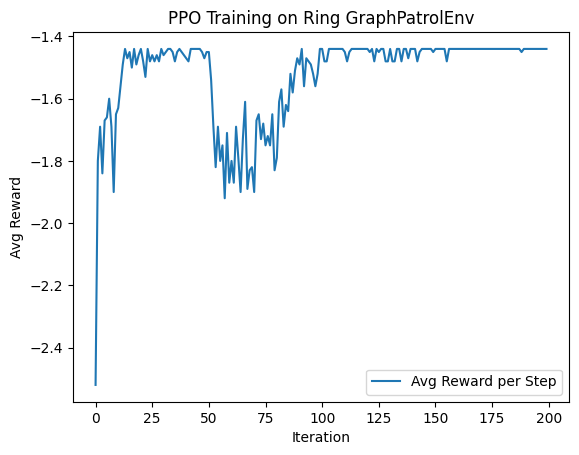

In [7]:
import matplotlib.pyplot as plt
env = GraphPatrolEnv(max_steps=20)

actor = GNNActor(hidden_dim=32)
critic = MLPCritic(hidden_dim=64)

trainer = PPOTrainer(actor, critic, env, actor_lr=1e-3, critic_lr=1e-3,
                         gamma=0.99, lam=0.95, clip_eps=0.2,
                         epochs=4, batch_size=16)

reward_history = trainer.train(num_iterations=200, rollout_size=50)

plt.plot(reward_history, label="Avg Reward per Step")
plt.xlabel("Iteration")
plt.ylabel("Avg Reward")
plt.title("PPO Training on Ring GraphPatrolEnv")
plt.legend()
plt.show()